# Simulation of Protein-Peptide Datasets for Benchmarking Evaluation and Quantification Methods 

Simulating datasets mimicing protein and peptide abundances of MS experiments for benchmarking purposes is one 
feature of PyProteoNet. Therefore, PyProteoNet provides a bunch of function to randomly draw and caluculate abundance values, simulate
several different errors and introduce missing values.

The following shows an example which starting from a MoleculeSet samples abundance values for proteins, computes peptide abundances
from those protein abundances and applies several random error which can also be observed in real-world datasets. Finally several missing values
are introduced to the dataset such that it can be used as a benchmark for protein imputation methods

We start of with a `MoleculeSet`. For creating real benchmarking datasets it might be useful to use a `MoleculeSet` from a
real-world dataset, however, here we use a small toy example.

In [3]:
import pandas as pd
from pyproteonet.data import MoleculeSet

proteins = pd.DataFrame(index=range(10))
peptides = pd.DataFrame(index=range(100))
mapping = pd.DataFrame({'peptide':peptides.index, 'protein':peptides.index % 10})
mapping.set_index(['peptide', 'protein'], inplace=True)

ms = MoleculeSet(molecules = {'protein':proteins, 'peptide':peptides},
                 mappings = {'peptide-protein': mapping}
                )

In [39]:
from pyproteonet.simulation.molecule_set import _relative_to_absolute_node_degrees, _degree_distribution_to_integers
from pyproteonet.simulation.utils import get_numpy_random_generator
import numpy as np

def simulate_molecule_set_protein_peptide(num_peptides = 1000, num_proteins = 100, 
                                          relative_peptide_node_degrees = [0.0, 0.75, 0.25],
                                          relative_protein_node_degrees = [0, 0, 0.2, 0.3, 0.5],
                                          random_seed = None, *args, **kwargs):
    rng = get_numpy_random_generator(seed=random_seed)
    #Simulate peptide to protein correspondences
    peptide_node_degrees = _relative_to_absolute_node_degrees(relative_peptide_node_degrees, num_peptides)
    protein_deg_distribution = None
    b_nodes_deg0 = 0
    if relative_protein_node_degrees is not None:
        num_edges = ((np.arange(len(peptide_node_degrees))) * peptide_node_degrees).sum()
        #protein_deg_distribution = np.array(_relative_to_absolute_node_degrees(relative_protein_node_degrees, num_proteins))
        protein_deg_distribution = np.array(relative_protein_node_degrees)
        protein_deg_distribution /= protein_deg_distribution.sum()
        protein_deg_distribution *= num_edges / (protein_deg_distribution * np.arange(len(protein_deg_distribution))).sum()
        b_nodes_deg0 = round(protein_deg_distribution[0])
        protein_deg_distribution = np.array(_degree_distribution_to_integers(protein_deg_distribution), dtype=int)
        print(protein_deg_distribution)
        protein_deg_distribution = np.repeat(np.arange(len(protein_deg_distribution)), protein_deg_distribution).astype(float)
        #protein_deg_distribution *= num_edges / protein_deg_distribution.sum()
        rng.shuffle(protein_deg_distribution)
    a_b = []
    start = 0
    a_nodes = []
    a_nodes_deg0 = []
    for deg, nwd in enumerate(peptide_node_degrees):
        nodes = np.arange(start, start + nwd)
        if deg==0:
            a_nodes_deg0.append(nodes)
        else:
            a_nodes.append(np.stack([nodes, np.full(nwd, deg)], axis=1))
        start += nwd
    a_nodes = np.concatenate(a_nodes, axis=0)
    rng.shuffle(a_nodes, axis=0)
    return protein_deg_distribution, a_nodes

In [40]:
prot, pep = simulate_molecule_set_protein_peptide(num_peptides=100, num_proteins=10)

[ 0  0  7 11 19]


In [41]:
prot_degs = [0.0, 0.75, 0.25]
pep_degs = [0, 0, 0.2, 0.3, 0.5]

In [38]:
#_relative_to_absolute_node_degrees

array([2., 2., 3., 2., 3., 3., 4., 4., 4., 4., 4., 2., 3., 3., 4., 3., 4.,
       4., 3., 4., 4., 2., 3., 4., 3., 4., 4., 4., 4., 4., 4., 4., 2., 4.,
       2., 3., 3.])

We start off creating a `Dataset` with protein abundances drawn from a normal distribution in log space
(usually the logarithm of protein and peptide abundances of real world datasets roughly follows a normal distribution).
We also apply a small error term (as well in log space).

In [6]:
from pyproteonet.simulation import draw_normal_log_space
dataset = draw_normal_log_space(
            molecule_set=ms,
            log_mu=10,
            log_sigma=5,
            samples=10,
            molecule='protein',
            column='abundance',
            log_error_mu = 0,
            log_error_sigma = 1,
          )

Given the protein abundance we can compute peptide abunces using the mapping from peptides to proteins.
Every peptide occurs in a set of proteins, so the theoretical peptide abundance should be the sum of protein abundances it occurs in.

In [8]:
from pyproteonet.processing.aggregation import neighbor_sum
dataset = neighbor_sum(dataset,
                        molecule='protein',
                        column='abundance',
                        mapping='peptide-protein',
                        result_molecule='peptide',
                        result_column='abundance',
                        only_unique=False,
                       )

In real-world datasets it can be observed that different some peptide are easier to detect than other. To simulate this we multiply
every peptide abundance with a scaling factor drawn once for every peptide.

In [9]:
from pyproteonet.simulation import per_molecule_random_scaling
dataset = per_molecule_random_scaling(dataset=dataset,
                                      beta_distr_alpha=2.5,
                                      beta_distr_beta=5,
                                      molecule='peptide',
                                      column='abundance',
                                     )

Finally, we simulate some peptide error (a background measurement noise as well as the counting nature of an MS experiment)
to make the resulting peptide abundances more realistic.

In [10]:
from pyproteonet.simulation import add_positive_gaussian, poisson_error
dataset = add_positive_gaussian(dataset,
                                molecule='peptide',
                                column='abundance',
                                sigma=0,
                                mu=5000,
                               )
dataset = poisson_error(dataset=dataset, molecule='peptide', column='abundance')

Last but not least we can simulate some missing values.
While MNARs are more likely to occur for low abundant values, MNARs are sampled completly at random across all molecules.

In [11]:
from pyproteonet.simulation import simulate_mnars_thresholding, simulate_mcars
dataset = simulate_mnars_thresholding(dataset, thresh_mu=7000, thresh_sigma=4000, molecule='peptide', column='abundance')
dataset = simulate_mcars(dataset, amount=0.2, molecule='peptide', column='abundance')

Thats it, we have created an in silico dataset. Lets plot its histogram across all samples!

Sidenote:
Instead of calling all those functions one by one, there also is a higher level
function called `simulate_protein_peptide_dataset(...)` in the simulation module.

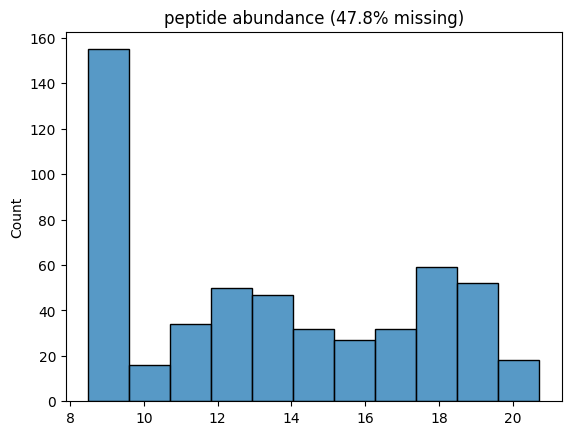

In [12]:
from pyproteonet.visualization import plot_hist
plot_hist(dataset, molecule='peptide', column='abundance', log_space=True)